##### Reinforcement Learning and Decision Making &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Project #2

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Lunar Lander

In [1]:
################
# DO NOT REMOVE
# Versions
# gym==0.17.2
# numpy==1.18.0
################
import gym
import numpy as np
import random
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Define the Q-network
class DQN(nn.Module):
    """
    implement a three-layer perceptron with hidden dimemsin 64
    DQN is used to approximate the optimal Q(s, a) function
    input: states (N, 8), 8 states for the Lunar lander problem
    output: Q value for each action (N, 4), 4 actions
    """
    def __init__(self, state_size, action_size, hidden_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [2]:
# Define the experience replay buffer
class ReplayBuffer():
    def __init__(self, buffer_size):
        # a deque that always store buffer_size records
        self.buffer = deque(maxlen=buffer_size)

    def add_a_record(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [3]:
# Define the DQN Agent
class DQNAgent():
    def __init__(self, state_dim, action_dim, hidden_dim, buffer_size, batch_size, gamma, epsilon, lr, w_soft):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma #discount rate
        self.epsilon = epsilon #exploration rate in epsilon-greedy
        self.lr = lr #learning rate
        self.w_soft = w_soft # the weight for soft updating

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.q_network = DQN(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = DQN(state_dim, action_dim, hidden_dim).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        self.q_network.eval()
        with torch.no_grad():
            q_values = self.q_network(state) #select action using DQN
        self.target_network.train()
        if random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            action = np.argmax(q_values.cpu().data.numpy())
        return action

    def one_step(self, state, action, reward, next_state, done):
        # one actual step in the game
        self.replay_buffer.add_a_record(state, action, reward, next_state, done)
        self.learn_on_buffer()
       

    def learn_on_buffer(self):
        if self.replay_buffer.__len__() < self.batch_size: #no enough data in buffer
            return
        # draw a batch from the buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = torch.from_numpy(np.array(states)).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).unsqueeze(1).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).unsqueeze(1).float().to(self.device)
        next_states = torch.from_numpy(np.array(next_states)).float().to(self.device)
        dones = torch.from_numpy(np.array(dones)).unsqueeze(1).float().to(self.device)
        
        q_values = self.q_network(states).gather(1, actions)
        target_q_values = self.target_network(next_states).detach().max(1)[0].unsqueeze(1) #updating using target network
        expected_q_values = rewards + (1 - dones) * self.gamma * target_q_values

        loss = self.loss_fn(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        #update target network
        self.soft_update_target_network()
   

    def soft_update_target_network(self):
        for q_param, target_param in zip(self.q_network.parameters(), self.target_network.parameters()):
            target_param.data.copy_(self.w_soft * q_param.data + (1 - self.w_soft) * target_param.data)

In [4]:
class DoubleDQN(object):
    def __init__(self, n_episodes_train, hidden_dim, buffer_size, batch_size, gamma, epsilon, lr, w_soft, save):
        self.Q = None
        self.n_episodes_train = n_episodes_train
        self.hidden_dim = hidden_dim
        self.env = gym.make("LunarLander-v2")
        self.env.seed(0)
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.w_soft = w_soft
        self.save = save
        self.agent = DQNAgent(state_dim=self.env.observation_space.shape[0], 
                              action_dim=self.env.action_space.n, hidden_dim=self.hidden_dim, 
                              buffer_size=self.buffer_size, batch_size=self.batch_size, 
                              gamma=self.gamma, epsilon=self.epsilon, 
                              lr=self.lr, w_soft=self.w_soft)
        self.reward_per_episode = []
        self.reward_100 = deque(maxlen=100)

    def solve(self):
        highest_avg_reward = 0 #used to select the best model
        for i in range(self.n_episodes_train):
            state = self.env.reset()
            done = False
            cum_reward = 0

            while not done:
                #agent select action
                action = self.agent.act(state)
                #interact with envoriment
                next_state, reward, done, _ = self.env.step(action)
                #update agent
                self.agent.one_step(state, action, reward, next_state, done)
                #transit
                state = next_state
                cum_reward += reward
                #terminal state
                if done:
                    break
            self.reward_per_episode.append(cum_reward) #length = n_episodes
            self.reward_100.append(cum_reward) #lenght = 100
            avg_reward = np.mean(self.reward_100)
            # if avg_reward > highest_avg_reward:
            #     highest_avg_reward = avg_reward
            #     # print('\rThe best average reward achieves at {} episode with {:.2f} reward'.format(i, highest_avg_reward))
            #     torch.save(self.agent.q_network.state_dict(), 'best_model.pth')
             
            if i % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, avg_reward))

            if avg_reward>=200.0:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i-100, avg_reward))
                if self.save:
                    torch.save(self.agent.q_network.state_dict(), 'bestmodel.pth')
                break
        return self.reward_per_episode


# Hyperparameter tuning: w_soft

In [5]:
w_soft_lst = [0, 0.1, 0.5, 0.8, 1]
tuning_w_result = {}
for w_soft in w_soft_lst:
    print(f"tunning w_soft: ", w_soft)
    mydqn = DoubleDQN(n_episodes_train=2000, hidden_dim = 64, 
                      buffer_size=100000, batch_size=64, gamma=0.99, epsilon=0.1, 
                      lr=0.001, w_soft=w_soft, save=False)
    training_rewards = mydqn.solve()
    tuning_w_result.setdefault(w_soft, training_rewards)

tunning w_soft:  0
Episode 0	Average Score: -497.51
Episode 100	Average Score: -186.97
Episode 200	Average Score: -154.74
Episode 300	Average Score: -168.26
Episode 400	Average Score: -145.30
Episode 500	Average Score: -125.16
Episode 600	Average Score: -137.29
Episode 700	Average Score: -136.61
Episode 800	Average Score: -101.77
Episode 900	Average Score: -91.23
Episode 1000	Average Score: -69.68
Episode 1100	Average Score: -87.64
Episode 1200	Average Score: -114.27
Episode 1300	Average Score: -108.81
Episode 1400	Average Score: -74.26
Episode 1500	Average Score: -91.94
Episode 1600	Average Score: -88.22
Episode 1700	Average Score: -43.61
Episode 1800	Average Score: -92.17
Episode 1900	Average Score: -67.52
tunning w_soft:  0.1
Episode 0	Average Score: -1434.36
Episode 100	Average Score: -144.16
Episode 200	Average Score: -28.15
Episode 300	Average Score: 133.14
Episode 400	Average Score: 160.28

Environment solved in 391 episodes!	Average Score: 200.56
tunning w_soft:  0.5
Episode 0	

In [6]:
import pandas as pd
df = pd.DataFrame.from_dict(tuning_w_result, orient='index').T
df.head(5)

,0.0,0.1,0.5,0.8,1.0
0,-497.511318,-1434.356004,-585.458229,-588.059593,-738.728012
1,-472.540118,-533.401979,-141.495981,-1005.347881,-365.672148
2,-504.067808,-181.998774,-349.147082,-855.611897,-342.229180
3,-454.158181,-147.747228,-202.597341,-72.964815,-534.312035
4,-57.864947,-303.327136,-142.594955,-278.656884,-586.493995


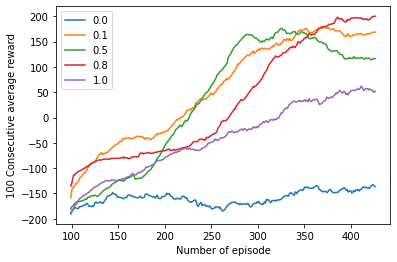

In [7]:
# Compute rolling average of 100 consecutive elements
window_size = 100
import matplotlib.pyplot as plt
%matplotlib inline
rolling_average = df.rolling(window=window_size, axis=0).mean().dropna()
rolling_average.plot()
# Add x-label and y-label
plt.xlabel('Number of episode')
plt.ylabel('100 Consecutive average reward')
plt.savefig("tuning_softw.jpg")
plt.show()